# Peak detection and orientation mapping example

Rebecca Leghziel, L. Houben, Weizmann Institute of Science, last updated in April 2025

In this notebook we use the nbed library to detect diffraction peaks in a 4D STEM nanobeam diffraction dataset, to create a list of Bragg peaks as input to the ACOM procedures in py4DSTEM. 

- Load a 4D STEM nanobeam diffraction data set
- Compensate descan shifts
- Adjust peak detection parameters in a subset of frames
- Visualize virtual image and generate a mask for frames of interest
- Run peak detection on all frames
- Convert peak coordinates to a py4DSTEM PointList for ACOM processing for frames of interest
- Test orientation mapping on a single frame
- Map orientation for each real space pixel
- Save the bragg peaks, pixel coordinates, correlation and orientation_matrix obtained for each frame

The 4D-STEM raw data file for input is available from https://doi.org/10.5281/zenodo.15212905

In [1]:
import numpy as np
import numpy.matlib
#from objbrowser import browse
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from scipy.optimize import curve_fit
import trackpy as tp

from IPython import display
%matplotlib inline
import os

# nbed module, available under https://github.com/LotharHouben/nbed/
import nbed
from nbed import ParabolaFit2D,bytscl
from xtal_omap.masking_functions import *

from emdfile import PointList
import py4DSTEM
from pymatgen.core.structure import Structure, Lattice

import time
from tqdm import tqdm

## Define filename, create class instance, load the data set, and display a single frame 
Currently supported formats: 
- PantaRhei .prz (default)
- EMPAD .raw

In [2]:
# Path definition and filename
# export format
path="/Users/rebeccaleghziel/Downloads/"
filebasename="Coccolith_013"
filesuffix="prz"

In [3]:
# create an instance of the pyNBED object and load data
myset=nbed.pyNBED()
myset.LoadFile(path+filebasename+'.'+filesuffix)

pyNBED: Loading object descriptor: /Users/rebeccaleghziel/Downloads/Coccolith_013.prz
pyNBED: Loading data ...
        finished
pyNBED: array dimensions: (222, 180, 256, 256)
pyNBED: Preparing reciprocal space sampling grid


## Find central diffraction peak locations and compensate the displacement
The data held by the class instance will be updated and hold the aligned frames. <br>
A second execution will display the residual displacements after correction with a second order polynomial.

locating strongest pixel in all frames ...
finished


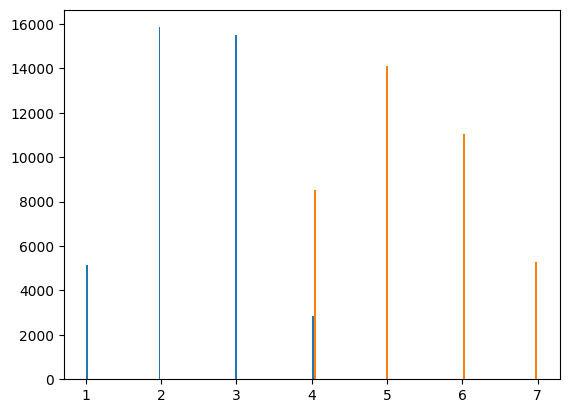

Displacement statistics along x, filtered for outliers (all indices):
Mean =  2.420238804423839 ( 2.3974974974974974 )
Max  =  4 ( 6 )
Min  =  1 ( -1 )
Displacement statistics along y, filtered for outliers (all indices):
Mean =  5.340205651532027 ( 5.306206206206206 )
Max  =  7 ( 9 )
Min  =  4 ( 2 )


In [4]:
(dx,dy)=myset.DiffractionShift(reject_sd=2, searchradius=20)

(39960,)


<Figure size 640x480 with 0 Axes>

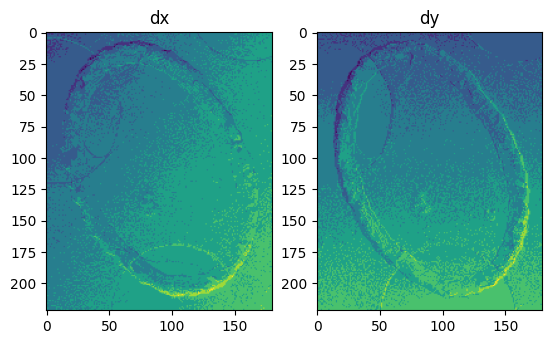

<Figure size 640x480 with 0 Axes>

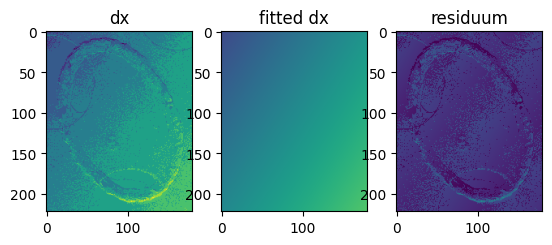

Residuum statistics dx-dxfit
Mean deviation:     -1.1848169376091276e-09
Max abs deviation:  2.7654298588678854
Mean abs deviation: 0.34274358139393274
(39960,)


<Figure size 640x480 with 0 Axes>

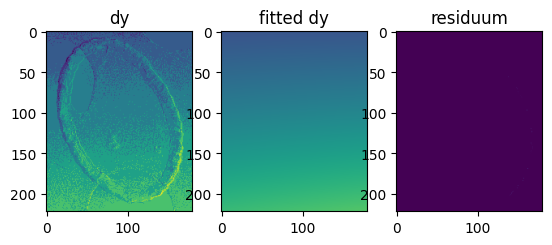

Residuum statistics dy-dyfit
Mean deviation:     -8.522902717245428e-11
Max abs deviation:  2.8370877334783335
Mean abs deviation: 0.3785177030623502
finished


In [5]:
myset.CompensateShift(dx,dy)

## Create a virtual aperture image

The data held by the class instance will be updated and hold the aligned frames.
A second execution will display the residual displacements after correction with a second order polynomial.

In [6]:
bf=myset.VirtualApertureImage(radius=15,invert=True)

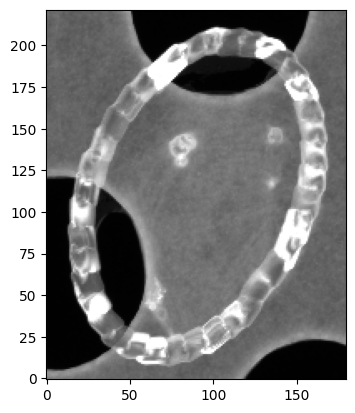

In [12]:
# Display the virtual image
plt.imshow(bytscl(bf,vmin=np.mean(bf)-2*np.std(bf),vmax=np.mean(bf)+2*np.std(bf)),cmap='gray',origin="lower");
plt.show()

## Define a mask (optional)
In order to reduce the computation time, we select the regions of the coccolith that we want to analyse using a mask.
We define the region as the crystals contained within two ellipses.
- Computation time without mask: 9hrs 54 min
- Computation time with mask: 3hrs 51 min

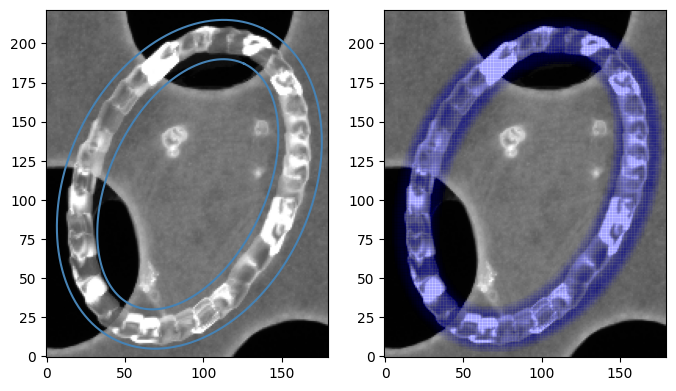

In [15]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 5))

# Define inner ellipse

x_inner, y_inner = 90, 110     # Center of the ellipse
a_inner, b_inner = 85, 50      # Semi-major and semi-minor axes
theta_deg_inner = 65           # Rotation angle in degrees
params_inner = [x_inner, y_inner, a_inner, b_inner, theta_deg_inner]

# Define outer ellipse

x_outer, y_outer = 91, 110
a_outer, b_outer = 110, 78
theta_deg_outer = 65
params_outer = [x_outer, y_outer, a_outer, b_outer, theta_deg_outer]

# generate the ellipse to plot for visualization and correction

x1, y1 = generate_ellipse(x_inner, y_inner, a_inner, b_inner, theta_deg_inner)
x2, y2 = generate_ellipse(x_outer, y_outer, a_outer, b_outer, theta_deg_outer)

y_coords, x_coords = generate_mask(params_inner, params_outer, bf)
coords = np.column_stack((y_coords, x_coords))

# Plot the two ellipses super imposed on virtual image

ax1.plot(x1, y1, color = 'steelblue')
ax1.plot(x2, y2, color = 'steelblue')
ax1.imshow(bytscl(bf,vmin=np.mean(bf)-2*np.std(bf),vmax=np.mean(bf)+2*np.std(bf)),cmap='gray',origin="lower") 

ax2.imshow(bytscl(bf,vmin=np.mean(bf)-2*np.std(bf),vmax=np.mean(bf)+2*np.std(bf)),cmap='gray',origin="lower")
ax2.scatter(x_coords, y_coords, alpha=0.006, marker='s', color='blue')

plt.gca().set_aspect('equal')
plt.show()

## Bragg Peak detection

Peak detection parameters are held in a dictionary. The parameter settings depend on the type of detection. Parameter presets are pre-defined for the DECTRIS ELA detector ('ELA') and the Cornell EMPAD detector ('EMPAD').
Parameters can be adapted. 

frame coordinates: 45 65
frame dimensions:  (256, 256)


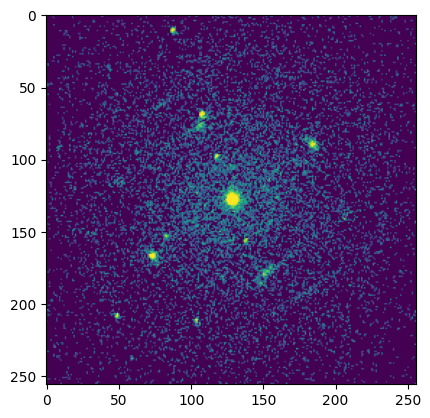

array([[0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.92932814]], shape=(256, 256), dtype=float32)

In [16]:
myset.ShowFrame(i=45, j=65,Log=True, sd=6)


In [17]:
pars=myset.PreparePeakDetectionPars(shortcut='ELA')
pars

{'feature_size': 7,
 'feature_minmass': 2.0,
 'feature_separation': 8,
 'feature_percentile': 65.0,
 'feature_threshold': 1.0,
 'noise_size': 1.0,
 'smooth_size': None,
 'frame_cmin': 1.0,
 'frame_cmax': 10.0,
 'frame_cutoff': 0.0,
 'conv2D': True}

Detect peaks in a sub-region. The Peak detection method uses a 1D index array for addressing the spatial pixels. The method LinearIndexArray converts the 2D coordinate ranges into a 1D array.

In [18]:
# adapt parameters
pars["feature_minmass"]=25 # mass - intensity of pixel
pars["feature_threshold"]=2
pars["feature_percentile"]= 65
pars["conv2D"]=False
pars["frame_cmax"]=10.

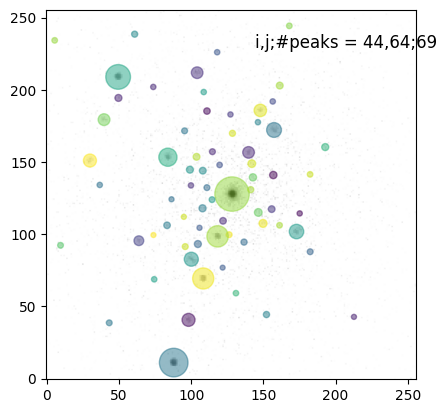

In [19]:
# cols = x, rows = y
cols=np.arange(40,45) # cols=np.arange(0,myset.dim[1]) 
rows=np.arange(60,65) # rows=np.arange(0,myset.dim[0])
indcs=myset.LinearIndexArray(cols,rows,is_roi=True)
framepeaklist=myset.PeakDetection(indcs,params=pars,animate=True)

In [20]:
# full image
cols=np.arange(0, myset.dim[1]) # X VALUES
rows=np.arange(0, myset.dim[0]) # Y VALUES
indcs=myset.LinearIndexArray(rows, cols, is_roi=True)
framepeaklist=myset.PeakDetection(indcs, params=pars, animate=False)

Processing Frames : 100%|████████████████| 39960/39960 [05:42<00:00, 116.55it/s]


## Conversion of data to be compatible with py4dstem

In [21]:
pl_dtype = np.dtype([
                        ("qx", "float64"),
                        ("qy", "float64"),
                        ("intensity", "float64"),
                        ("h", "int"),
                        ("k", "int"),
                        ("l", "int"),
                    ])

In [22]:
pxl_coordinates = []
braggpeaks_array = []
sr = 0.0855*0.1

# SET BRAGG PEAKS HERE

for fp in tqdm(framepeaklist, desc="Defining Bragg Peaks"):

    # pixel coordinate
    i_value = fp['i'] # y coordinate
    j_value = fp['j'] # x coordinate

    if [i_value, j_value] in coords.tolist():
        
        pxl_coordinates.append([i_value, j_value])
        bragg_peaks = PointList(np.array([], dtype=pl_dtype)) # an empty array of PointList records
        
        for i in range(0, len(fp['x'])):
            vec=np.array((sr*fp['x'][i], sr*fp['y'][i], fp['mass'][i]/fp['mass'][0] , 0, 0, 0),dtype=pl_dtype)
            bragg_peaks.add(vec)
        
        braggpeaks_array.append(bragg_peaks)


Defining Bragg Peaks: 100%|██████████████| 39960/39960 [01:15<00:00, 532.71it/s]


In [23]:
# SAVE THE BRAGG PEAKS
folder_path = '/Users/rebeccaleghziel/Desktop/NBED_013'

bragg_peaks = np.array(braggpeaks_array, dtype=object)
pxl_coordinates = np.array(pxl_coordinates)

np.save(f'{folder_path}/braggpeaks_array.npy', bragg_peaks)
np.save(f'{folder_path}/pxl_coordinates.npy', pxl_coordinates)

## Testing the orientation mapping on a single pixels

In [24]:
cif_file_path = '/Users/rebeccaleghziel/git/xtal_omap/data/CalciteRhombohedral.cif'
calcite = py4DSTEM.process.diffraction.Crystal.from_CIF(cif_file_path)
k_max = 1.2
calcite.calculate_structure_factors(k_max)
calcite.setup_diffraction(200e3)
calcite.orientation_plan(
     angle_step_zone_axis = 1,
     angle_step_in_plane = 1,
     accel_voltage = 200e3,
     corr_kernel_size=0.08,
     zone_axis_range='auto',
    )


/Users/rebeccaleghziel/anaconda3/envs/crystalmap/lib/python3.13/site-packages/py4DSTEM/process/diffraction/crystal.py:161: FutureWarning: get_structures is deprecated; use parse_structures in pymatgen.io.cif instead.
The only difference is that primitive defaults to False in the new parse_structures method.So parse_structures(primitive=True) is equivalent to the old behavior of get_structures().
  structure = parser.get_structures()[0]


Automatically detected point group -3m,
 using arguments: zone_axis_range = 
fiber, 
 fiber_axis=[0, 0, 1], fiber_angles=[90.0, 60.0].


Orientation plan: 100%|███████████| 4186/4186 [00:03<00:00, 1085.97 zone axes/s]


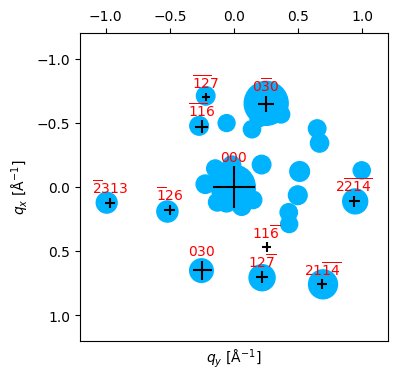

In [26]:
# test single pattern matching
n =106
orientation = calcite.match_single_pattern(braggpeaks_array[n])
    
# Add a section to save the figure of the orientation match
bragg_peaks_fit = calcite.generate_diffraction_pattern(
    orientation_matrix = orientation.matrix[0],
    sigma_excitation_error=0.01)

fig = py4DSTEM.process.diffraction.plot_diffraction_pattern(
    bragg_peaks_fit,
    bragg_peaks_compare=bragg_peaks[n],
    scale_markers = 3000,
    scale_markers_compare = 1000,
    plot_range_kx_ky=[k_max,k_max],
    figsize=(4,4),
    returnfig = True,

)

## Orientation matching 

We iterate through all the pixels in the image and perform the orientation matching with py4dstem.

In [22]:
start_time = time.time()

orientation_matrix = []
corr_matrix = []

for bragg_peaks in tqdm(braggpeaks_array, desc="Processing Bragg Peaks"):
    
    orientation = calcite.match_single_pattern(bragg_peaks)
    orientation_matrix.append(orientation.matrix)
    corr_matrix.append(orientation.corr)

end_time = time.time()
elapsed_time = end_time - start_time
print("Elapsed time for processing:", elapsed_time, "seconds")

Processing Bragg Peaks: 100%|███████████| 13604/13604 [3:51:04<00:00,  1.02s/it]

Elapsed time for processing: 13864.132329940796 seconds


In [23]:
# Convert lists to NumPy arrays and save to folder
orientation_matrix = np.array(orientation_matrix)
corr_matrix = np.array(corr_matrix)

# Save the arrays
np.save(f'{folder_path}/orientation_matrix.npy', orientation_matrix)
np.save(f'{folder_path}/corr_matrix.npy', corr_matrix)